In [ ]:
#Import TensorFlow
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import TensorBoard

import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import confusion_matrix , precision_score , recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [ ]:
'''
The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class.
The dataset is divided into 50,000 training images and 10,000 testing images.
The classes are mutually exclusive and there is no overlap between them.
'''
(train_images_1, train_labels_1), (test_images_1, test_labels_1) = datasets.cifar10.load_data()

In [ ]:
print('X_train: ' + str(train_images_1.shape))
print('Y_train: ' + str(train_labels_1.shape))
print('X_test:  ' + str(test_images_1.shape))
print('Y_test:  ' + str(test_labels_1.shape))

X_train: (50000, 32, 32, 3)
Y_train: (50000, 1)
X_test:  (10000, 32, 32, 3)
Y_test:  (10000, 1)


In [ ]:
'''
MNIST contains 70,000 images of handwritten digits. Each observation is a 28x28 pixel gray-scale image
that depicts a handwritten version of 1 of the 10 possible digits (0-9).
'''
(train_images_2, train_labels_2), (test_images_2, test_labels_2) = datasets.mnist.load_data()

In [ ]:
print('X_train: ' + str(train_images_2.shape))
print('Y_train: ' + str(train_labels_2.shape))
print('X_test:  ' + str(test_images_2.shape))
print('Y_test:  ' + str(test_labels_2.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [ ]:
# Normalize pixel values to be between 0 and 1 for the two datasets
train_images_1, test_images_1 = train_images_1 / 255.0, test_images_1 / 255.0

train_images_2, test_images_2 = train_images_2 / 255.0, test_images_2 / 255.0

# Peforming reshaping operation for MNIST dataset to add a channel to the dataset to indicate the color which is 1 (Grayscale)
train_images_2 = train_images_2.reshape(train_images_2.shape[0], 28, 28, 1)
test_images_2= test_images_2.reshape(test_images_2.shape[0], 28, 28, 1)

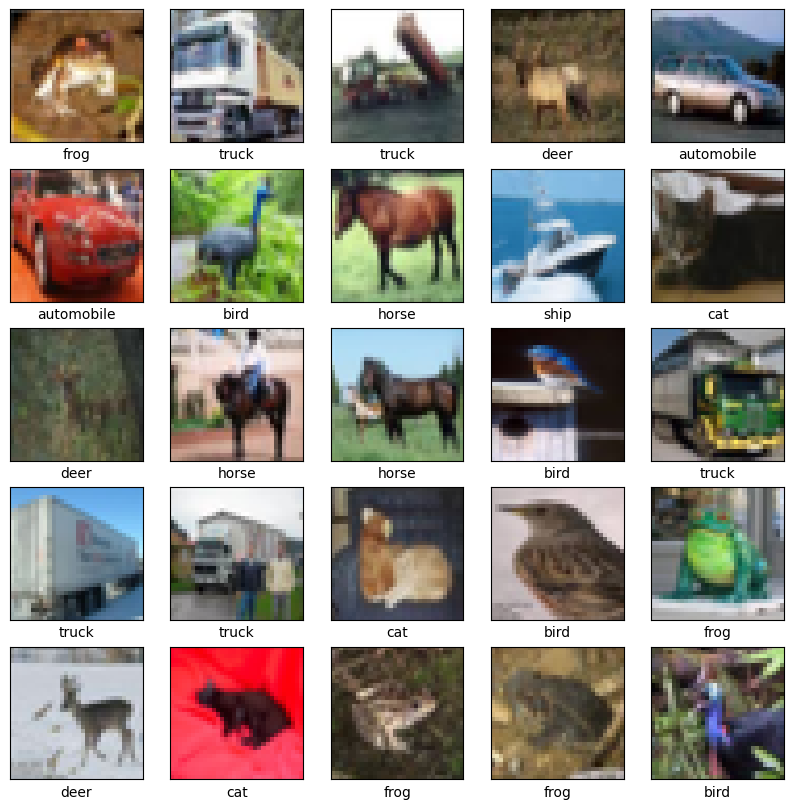

In [ ]:
# For CIFAR10 dataset, let's plot the first 25 images from the training set and display the class name below each image.

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_1[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels_1[i][0]])
plt.show()

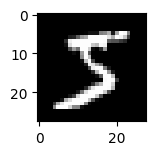

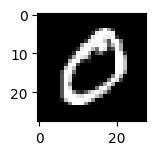

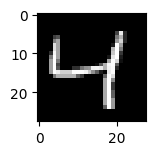

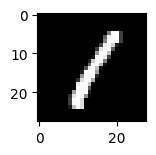

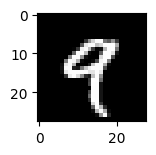

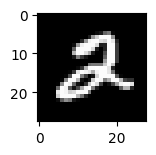

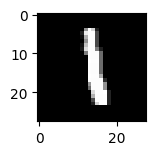

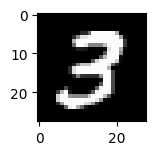

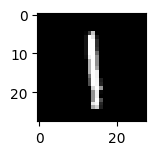

In [ ]:
# For MNIST dataset, let's plot the first 9 numbers from the training set
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_images_2[i], cmap=plt.get_cmap('gray'))
  plt.show()

In [ ]:
'''
AlexNet Architecture
Below we defined the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.
As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size where the color_channels refers to (R,G,B).
In this example, we will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images.
We can do this by passing the argument input_shape to our first layer.
'''
# Building AlexNet architecture for CIFAR10 dataset
alex_net = tf.keras.Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation= 'relu', input_shape= (32, 32, 3)),BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')])

In [ ]:
# Here's the complete architecture of our model
alex_net.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 6, 6, 96)          34944     
                                                                 
 batch_normalization_10 (Ba  (None, 6, 6, 96)          384       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 3, 3, 96)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 256)         614656    
                                                                 
 batch_normalization_11 (Ba  (None, 3, 3, 256)         1024      
 tchNormalization)                                               
                                                      

In [ ]:
#Compile and train the model
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

alex_net.compile(optimizer=sgd,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')

history = alex_net.fit(train_images_1, train_labels_1, epochs=8, verbose=1, callbacks=[early_stopping],
                    validation_data=(test_images_1, test_labels_1))

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 1193s 762ms/step - loss: 1.8336 - accuracy: 0.3367 - val_loss: 1.7048 - val_accuracy: 0.3790
Epoch 2/8
1563/1563 [==============================] - 1180s 755ms/step - loss: 1.5606 - accuracy: 0.4407 - val_loss: 1.5376 - val_accuracy: 0.4316
Epoch 3/8
1563/1563 [==============================] - 1075s 688ms/step - loss: 1.4225 - accuracy: 0.4979 - val_loss: 1.4445 - val_accuracy: 0.4994
Epoch 4/8
1563/1563 [==============================] - 1111s 711ms/step - loss: 1.3394 - accuracy: 0.5270 - val_loss: 1.3999 - val_accuracy: 0.5020
Epoch 5/8
1563/1563 [==============================] - 1194s 764ms/step - loss: 1.2703 - accuracy: 0.5543 - val_loss: 1.3245 - val_accuracy: 0.5327
Epoch 6/8
1563/1563 [==============================] - 1220s 780ms/step - loss: 1.1961 - accuracy: 0.5823 - val_loss: 1.2547 - val_accuracy: 0.5550
Epoch 7/8
1563/1563 [==============================] - 1340s 858ms/step - loss: 1.1213 - accuracy: 0.6094 - val_loss: 1.32

313/313 - 23s - loss: 1.2025 - accuracy: 0.5823 - 23s/epoch - 75ms/step


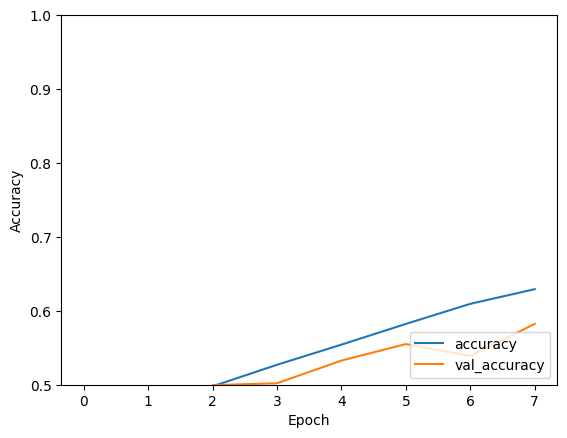

In [ ]:
# Evaluate the model (Metric: Accuracy)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = alex_net.evaluate(test_images_1,  test_labels_1, verbose=2)

In [ ]:
print(test_acc)

0.5823000073432922


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix , precision_score , recall_score
from sklearn.metrics import ConfusionMatrixDisplay

# Create the confusion matrix
predictions = alex_net.predict(test_images_1)
predictedLabels = np.argmax(predictions, axis=1)
conf_mat = confusion_matrix(test_labels_1, predictedLabels)

313/313 [==============================] - 23s 72ms/step


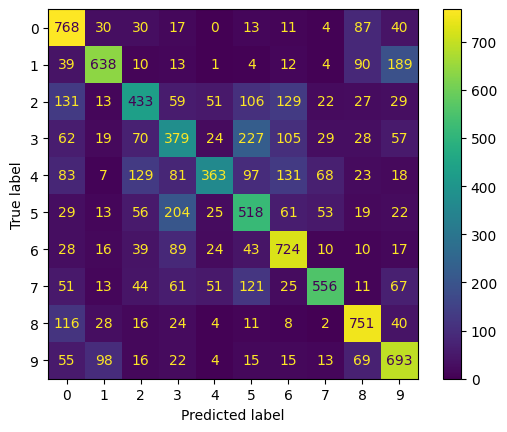

In [ ]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

In [ ]:
# Getting the precision, Recall and F1_score Metrics
from sklearn.metrics import classification_report
print(classification_report(test_labels_1, predictedLabels))

              precision    recall  f1-score   support

           0       0.56      0.77      0.65      1000
           1       0.73      0.64      0.68      1000
           2       0.51      0.43      0.47      1000
           3       0.40      0.38      0.39      1000
           4       0.66      0.36      0.47      1000
           5       0.45      0.52      0.48      1000
           6       0.59      0.72      0.65      1000
           7       0.73      0.56      0.63      1000
           8       0.67      0.75      0.71      1000
           9       0.59      0.69      0.64      1000

    accuracy                           0.58     10000
   macro avg       0.59      0.58      0.58     10000
weighted avg       0.59      0.58      0.58     10000



In [ ]:
# Building the AlexNet Architecture for MNIST dataset
alex_net = tf.keras.Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation= 'relu', input_shape= (28, 28, 1)),BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')])

In [ ]:
# Here's the complete architecture of our model
alex_net.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_15 (Ba  (None, 5, 5, 96)          384       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 3, 3, 96)          0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 3, 3, 256)         614656    
                                                                 
 batch_normalization_16 (Ba  (None, 3, 3, 256)         1024      
 tchNormalization)                                               
                                                      

In [ ]:
# Compile and train the model
alex_net.compile(optimizer=sgd,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, verbose=1, mode='min')

history = alex_net.fit(train_images_2, train_labels_2, epochs=5, verbose=1, callbacks=[early_stopping],
                    validation_data=(test_images_2, test_labels_2))

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 1284s 684ms/step - loss: 0.2185 - accuracy: 0.9373 - val_loss: 0.2279 - val_accuracy: 0.9406
Epoch 2/5
1875/1875 [==============================] - 1266s 675ms/step - loss: 0.0872 - accuracy: 0.9753 - val_loss: 0.0751 - val_accuracy: 0.9801
Epoch 3/5
1875/1875 [==============================] - 1259s 672ms/step - loss: 0.0607 - accuracy: 0.9831 - val_loss: 0.0484 - val_accuracy: 0.9865
Epoch 4/5
1875/1875 [==============================] - 1258s 671ms/step - loss: 0.0479 - accuracy: 0.9862 - val_loss: 0.0441 - val_accuracy: 0.9868
Epoch 5/5
1875/1875 [==============================] - 1271s 678ms/step - loss: 0.0396 - accuracy: 0.9886 - val_loss: 0.0493 - val_accuracy: 0.9862


313/313 - 19s - loss: 0.0493 - accuracy: 0.9862 - 19s/epoch - 61ms/step


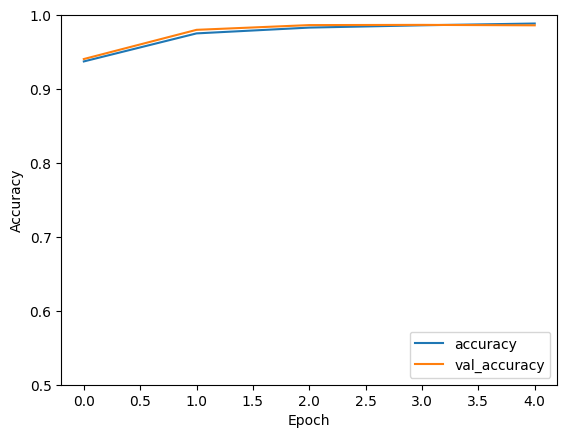

In [ ]:
# Evaluate the model (Metric: Accuracy)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = alex_net.evaluate(test_images_2,  test_labels_2, verbose=2)

313/313 [==============================] - 21s 65ms/step


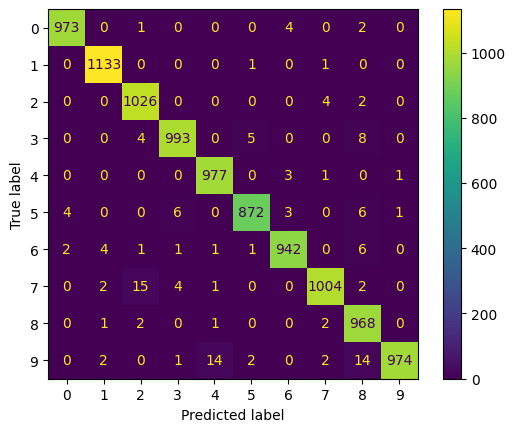

In [ ]:
# Create the confusion matrix
predictions = alex_net.predict(test_images_2)
predictedLabels = np.argmax(predictions, axis=1)
conf_mat = confusion_matrix(test_labels_2, predictedLabels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

In [ ]:
# Getting the precision, Recall and F1_score Metrics
print(classification_report(test_labels_2, predictedLabels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.98      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.96      0.99      0.98       974
           9       1.00      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
# Building VGG-16 Architecture for CIFAR10 dataset
vgg_16 = tf.keras.Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation= 'relu', input_shape= (32, 32, 3)),BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(10, activation='softmax')])

In [ ]:
# Here's the complete architecture of our model
vgg_16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization_20 (Ba  (None, 30, 30, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_21 (Conv2D)          (None, 30, 30, 64)        36928     
                                                                 
 batch_normalization_21 (Ba  (None, 30, 30, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 15, 15, 64)        0         
 ng2D)                                                           
                                                      

In [ ]:
# Compile and train the model
vgg_16.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = vgg_16.fit(train_images_1, train_labels_1, epochs=10,
                    validation_data=(test_images_1, test_labels_1))

Epoch 1/10
1563/1563 [==============================] - 71s 40ms/step - loss: 1.1653 - accuracy: 0.5983 - val_loss: 1.0821 - val_accuracy: 0.6452
Epoch 2/10
1563/1563 [==============================] - 63s 40ms/step - loss: 0.8598 - accuracy: 0.7131 - val_loss: 1.2031 - val_accuracy: 0.6202
Epoch 3/10
1563/1563 [==============================] - 65s 42ms/step - loss: 0.7029 - accuracy: 0.7713 - val_loss: 0.8511 - val_accuracy: 0.7191
Epoch 4/10
1563/1563 [==============================] - 64s 41ms/step - loss: 0.5710 - accuracy: 0.8150 - val_loss: 0.6323 - val_accuracy: 0.7985
Epoch 5/10
1563/1563 [==============================] - 70s 45ms/step - loss: 0.4637 - accuracy: 0.8488 - val_loss: 0.7211 - val_accuracy: 0.7723
Epoch 6/10
1563/1563 [==============================] - 62s 40ms/step - loss: 0.3780 - accuracy: 0.8762 - val_loss: 0.6044 - val_accuracy: 0.8152
Epoch 7/10
1563/1563 [==============================] - 68s 43ms/step - loss: 0.3064 - accuracy: 0.9015 - val_loss: 0.6024 -

313/313 - 3s - loss: 0.7990 - accuracy: 0.8197 - 3s/epoch - 9ms/step


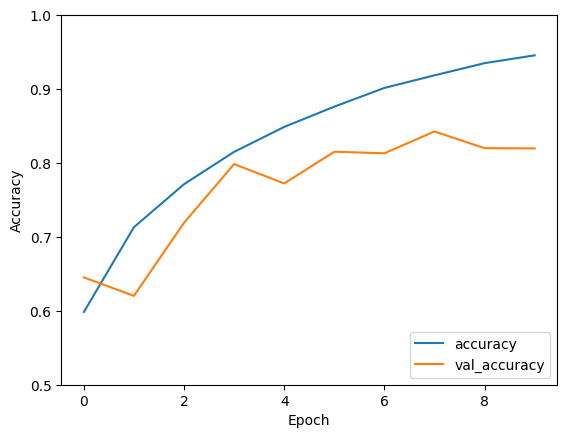

In [ ]:
# Evaluate the model (Metric: Accuracy)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = vgg_16.evaluate(test_images_1,  test_labels_1, verbose=2)

313/313 [==============================] - 3s 8ms/step


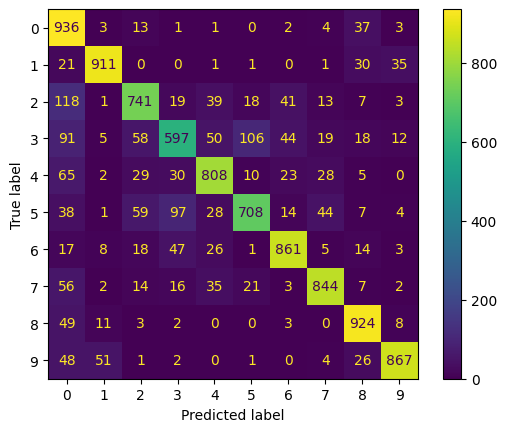

In [ ]:
# Create the confusion matrix
predictions = vgg_16.predict(test_images_1)
predictedLabels = np.argmax(predictions, axis=1)
conf_mat = confusion_matrix(test_labels_1, predictedLabels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

In [ ]:
# Getting the precision, Recall and F1_score Metrics
print(classification_report(test_labels_1, predictedLabels))

              precision    recall  f1-score   support

           0       0.65      0.94      0.77      1000
           1       0.92      0.91      0.91      1000
           2       0.79      0.74      0.77      1000
           3       0.74      0.60      0.66      1000
           4       0.82      0.81      0.81      1000
           5       0.82      0.71      0.76      1000
           6       0.87      0.86      0.86      1000
           7       0.88      0.84      0.86      1000
           8       0.86      0.92      0.89      1000
           9       0.93      0.87      0.90      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



In [ ]:
# Before we use the MNIST dataset on VGG-16, Convert the images into 3 channels as MNIST images are Black and White so they have 1 channel
train_images_2_mod = np.dstack([train_images_2] * 3)
test_images_2_mod = np.dstack([test_images_2] * 3)

# Then, we reshape images as per the tensor format required by tensorflow
train_images_2_mod = train_images_2_mod.reshape(-1, 28, 28, 3)
test_images_2_mod = test_images_2_mod.reshape (-1, 28, 28, 3)

# Resize the images 48*48 as required by VGG16
from keras.preprocessing.image import img_to_array, array_to_img

train_images_2_mod = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_images_2_mod])
test_images_2_mod = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_images_2_mod])

In [ ]:
# Building VGG-16 Architecture for MNIST dataset
vgg_16 = tf.keras.Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation= 'relu', input_shape= (48, 48, 3)),BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'),BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(10, activation='softmax')])

In [ ]:
# Here's the complete architecture of our model
vgg_16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 46, 46, 64)        1792      
                                                                 
 batch_normalization_13 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_14 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_14 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                      

In [ ]:
# Compile and train the model
vgg_16.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = vgg_16.fit(train_images_2_mod, train_labels_2, epochs=10,
                    validation_data=(test_images_2_mod, test_labels_2))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 112s 55ms/step - loss: 2.0838 - accuracy: 0.2406 - val_loss: 1.8840 - val_accuracy: 0.3137
Epoch 2/10
1875/1875 [==============================] - 102s 54ms/step - loss: 1.8497 - accuracy: 0.3303 - val_loss: 1.8266 - val_accuracy: 0.3350
Epoch 3/10
1875/1875 [==============================] - 100s 54ms/step - loss: 1.7683 - accuracy: 0.3643 - val_loss: 1.7217 - val_accuracy: 0.3868
Epoch 4/10
1875/1875 [==============================] - 100s 54ms/step - loss: 1.7501 - accuracy: 0.3727 - val_loss: 1.7480 - val_accuracy: 0.3861
Epoch 5/10
1875/1875 [==============================] - 100s 53ms/step - loss: 1.6846 - accuracy: 0.3945 - val_loss: 1.8700 - val_accuracy: 0.3112
Epoch 6/10
1875/1875 [==============================] - 101s 54ms/step - loss: 1.6673 - accuracy: 0.3990 - val_loss: 1.7190 - val_accuracy: 0.4013
Epoch 7/10
1875/1875 [==============================] - 102s 54ms/step - loss: 1.6516 - accuracy: 0.4059 - val_loss: 1.9315 - val

313/313 - 4s - loss: 20.9915 - accuracy: 0.3381 - 4s/epoch - 14ms/step


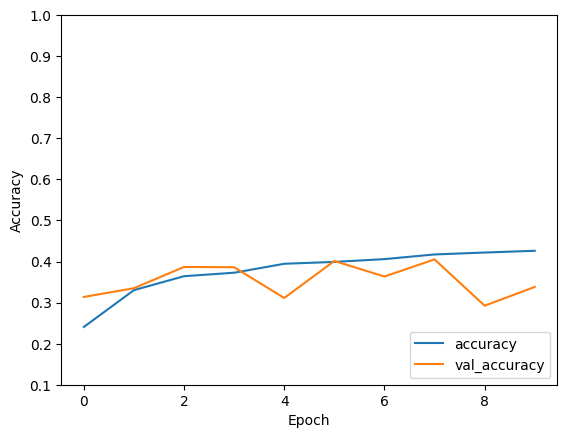

In [ ]:
# Evaluate the model (Metric: Accuracy)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = vgg_16.evaluate(test_images_2_mod,  test_labels_2, verbose=2)

313/313 [==============================] - 4s 13ms/step


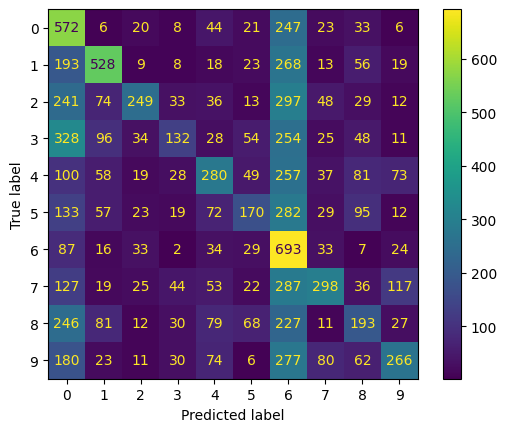

In [ ]:
# Create the confusion matrix
predictions = vgg_16.predict(test_images_2_mod)
predictedLabels = np.argmax(predictions, axis=1)
conf_mat = confusion_matrix(test_labels_2, predictedLabels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

In [ ]:
# Getting the precision, Recall and F1_score Metrics
print(classification_report(test_labels_2, predictedLabels))

              precision    recall  f1-score   support

           0       0.26      0.58      0.36       980
           1       0.55      0.47      0.50      1135
           2       0.57      0.24      0.34      1032
           3       0.40      0.13      0.20      1010
           4       0.39      0.29      0.33       982
           5       0.37      0.19      0.25       892
           6       0.22      0.72      0.34       958
           7       0.50      0.29      0.37      1028
           8       0.30      0.20      0.24       974
           9       0.47      0.26      0.34      1009

    accuracy                           0.34     10000
   macro avg       0.40      0.34      0.33     10000
weighted avg       0.41      0.34      0.33     10000



In [ ]:
from keras.applications import imagenet_utils
# Building our custom VGG-16 model
"""
First we use the pretrained VGG-16 and since we excluded the output layer, we will take the output of the last layer before the output layer. Then, We
will flatten this last layer and dense it(densing here is used to increase the accuracy of the model). Finally, we add the output layer.
After that we should have built the model using the weights pretrained VGG-16 and the output layer of our VGG-16
"""
"""
Building our custom model(pretrained + our model) starting from input_layer which will have the input layer + Pretrained VGG-16 layers(without output layer)
+ dense + output layer ---> This will be our model
"""
input_layer = layers.Input(shape=(48,48,3))

# Using Pretrained VGG-16 but with include_top=False
pretrained_vgg_16 = tf.keras.applications.vgg16.VGG16(weights='imagenet', input_tensor=input_layer, include_top=False, classes=10)

# Freeze the layers in the pre-trained model except the last layer
for layer in pretrained_vgg_16.layers[:-1]:
    layer.trainable=False

pretrained_vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# Using the output layer of our VGG-16 model
last_layer = pretrained_vgg_16.output

# Add flatten layer
flatten = layers.Flatten()(last_layer)

# Add dense layer
dense = layers.Dense(100,activation='relu')(flatten)

# Add dense layer to the final output layer
output_layer = layers.Dense(10,activation='softmax')(dense)

# Creating a model with input_layer and output_layer
custom_vgg = models.Model(inputs=input_layer, outputs=output_layer)

custom_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# Compile and train the model
custom_vgg.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = custom_vgg.fit(train_images_2_mod, train_labels_2, epochs=10,
                    validation_data=(test_images_2_mod, test_labels_2))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 35s 14ms/step - loss: 2.0988 - accuracy: 0.2363 - val_loss: 2.0102 - val_accuracy: 0.2776
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 1.9798 - accuracy: 0.2831 - val_loss: 1.9471 - val_accuracy: 0.2964
Epoch 3/10
1875/1875 [==============================] - 29s 16ms/step - loss: 1.9318 - accuracy: 0.3019 - val_loss: 1.9317 - val_accuracy: 0.3096
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 1.8965 - accuracy: 0.3158 - val_loss: 1.9020 - val_accuracy: 0.3051
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 1.8684 - accuracy: 0.3278 - val_loss: 1.8688 - val_accuracy: 0.3331
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - loss: 1.8469 - accuracy: 0.3361 - val_loss: 1.8351 - val_accuracy: 0.3428
Epoch 7/10
1875/1875 [==============================] - 26s 14ms/step - loss: 1.8287 - accuracy: 0.3424 - val_loss: 1.8153 - val_accura

313/313 - 4s - loss: 1.8131 - accuracy: 0.3467 - 4s/epoch - 13ms/step


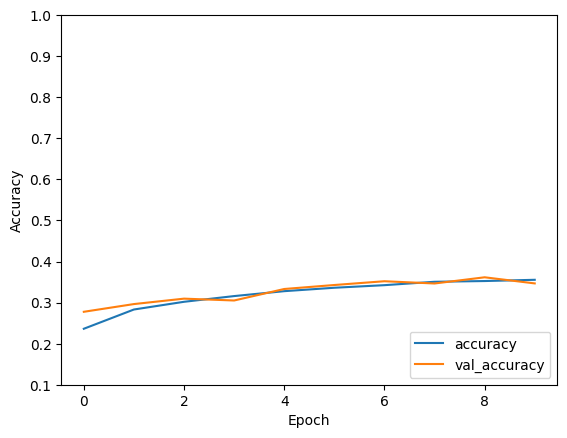

In [ ]:
# Evaluate the model (Metric: Accuracy)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = custom_vgg.evaluate(test_images_2_mod,  test_labels_2, verbose=2)

In [ ]:
from keras.layers import Input, Add, Activation, ZeroPadding2D, AveragePooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform

In [ ]:
# Identity Block
def identity_block(X, f, filters, stage, block):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
# Convolutional Block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ## Main Path ##
    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ## Shortcut Path ##
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape = (32, 32, 3), classes = 10):
    """
    Implementation of the ResNet50 architecture is the following:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name='avg_pool')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    # Create model
    model = models.Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
# Building the ResNet50 Architecture for CIFAR10 dataset
resnet_50 = ResNet50(input_shape = (32, 32, 3), classes = 10)

# Compile and train the model
resnet_50.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = resnet_50.fit(train_images_1, train_labels_1, epochs=10,
                    validation_data=(test_images_1, test_labels_1))

# Here's the complete architecture of our model
resnet_50.summary()

Epoch 1/10
1563/1563 [==============================] - 110s 53ms/step - loss: 2.0759 - accuracy: 0.3382 - val_loss: 1.9527 - val_accuracy: 0.4054
Epoch 2/10
1563/1563 [==============================] - 79s 50ms/step - loss: 1.8242 - accuracy: 0.3771 - val_loss: 2.2376 - val_accuracy: 0.2193
Epoch 3/10
1563/1563 [==============================] - 79s 51ms/step - loss: 1.7624 - accuracy: 0.4132 - val_loss: 2.2487 - val_accuracy: 0.4012
Epoch 4/10
1563/1563 [==============================] - 77s 49ms/step - loss: 1.4863 - accuracy: 0.4789 - val_loss: 1.5453 - val_accuracy: 0.4975
Epoch 5/10
1563/1563 [==============================] - 77s 50ms/step - loss: 1.2990 - accuracy: 0.5347 - val_loss: 1.4669 - val_accuracy: 0.5033
Epoch 6/10
1563/1563 [==============================] - 78s 50ms/step - loss: 1.1602 - accuracy: 0.5843 - val_loss: 1.2400 - val_accuracy: 0.5890
Epoch 7/10
1563/1563 [==============================] - 78s 50ms/step - loss: 1.0358 - accuracy: 0.6326 - val_loss: 1.0917 

313/313 - 4s - loss: 0.9961 - accuracy: 0.6624 - 4s/epoch - 13ms/step


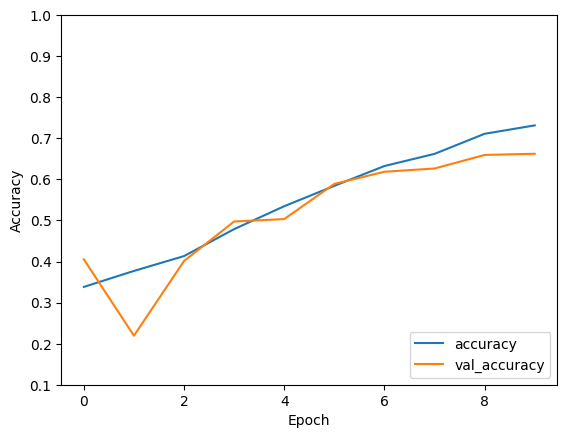

In [ ]:
# Evaluate the model (Metric: Accuracy)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = resnet_50.evaluate(test_images_1,  test_labels_1, verbose=2)

313/313 [==============================] - 5s 12ms/step


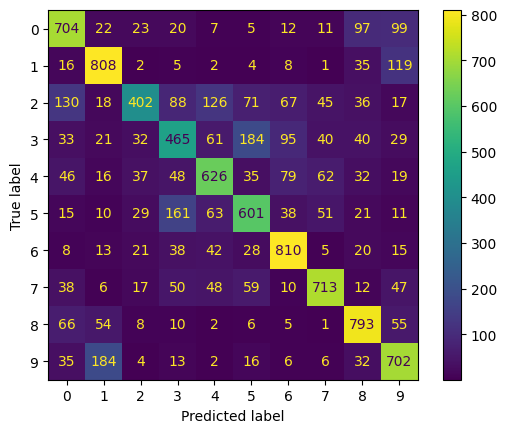

In [ ]:
# Create the confusion matrix
predictions = resnet_50.predict(test_images_1)
predictedLabels = np.argmax(predictions, axis=1)
conf_mat = confusion_matrix(test_labels_1, predictedLabels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

In [ ]:
# Building our custom ResNet-50 model
"""
First we use the pretrained ResNet50 and since we excluded the output layer, we will take the output of the last layer before the output layer. Then, We
will flatten this last layer and dense it(densing here is used to increase the accuracy of the model). Finally, we add the output layer.
After that we should have built the model using the weights pretrained ResNet50 and the output layer of our ResNet50
"""
"""
Building our custom model(pretrained + our model) starting from input_layer which will have the input layer + Pretrained ResNet50 layers(without output layer)
+ dense + output layer ---> This will be our model
"""
input_layer = layers.Input(shape=(32,32,3))

# Using Pretrained ResNet-50 but with include_top=False
pretrained_resnet_50 = tf.keras.applications.resnet50.ResNet50(weights='imagenet', input_tensor=input_layer, include_top=False, classes=10)

# Freeze the layers in the pre-trained model except the last layer
for layer in pretrained_resnet_50.layers[:-1]:
    layer.trainable=False

pretrained_resnet_50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
last_layer = pretrained_resnet_50.output

# Add flatten layer
flatten = layers.Flatten()(last_layer)

# Add dense layer
dense = layers.Dense(100,activation='relu')(flatten)

# Add dense layer to the final output layer
output_layer = layers.Dense(10,activation='softmax')(dense)

# Creating a model with input_layer and output_layer
custom_resnet = models.Model(inputs=input_layer, outputs=output_layer)

# Here's the complete architecture of our model
custom_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
# Compile and train the model
custom_resnet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = custom_resnet.fit(train_images_1, train_labels_1, epochs=10,
                    validation_data=(test_images_1, test_labels_1))

Epoch 1/10
1563/1563 [==============================] - 30s 17ms/step - loss: 2.0494 - accuracy: 0.2442 - val_loss: 1.9153 - val_accuracy: 0.2949
Epoch 2/10
1563/1563 [==============================] - 21s 14ms/step - loss: 1.8824 - accuracy: 0.3133 - val_loss: 1.8188 - val_accuracy: 0.3466
Epoch 3/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.8223 - accuracy: 0.3393 - val_loss: 1.8096 - val_accuracy: 0.3422
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.7943 - accuracy: 0.3505 - val_loss: 1.7334 - val_accuracy: 0.3796
Epoch 5/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.7689 - accuracy: 0.3623 - val_loss: 1.7704 - val_accuracy: 0.3563
Epoch 6/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.7486 - accuracy: 0.3703 - val_loss: 1.7144 - val_accuracy: 0.3895
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.7393 - accuracy: 0.3737 - val_loss: 1.6976 -

313/313 - 3s - loss: 1.7295 - accuracy: 0.3872 - 3s/epoch - 11ms/step


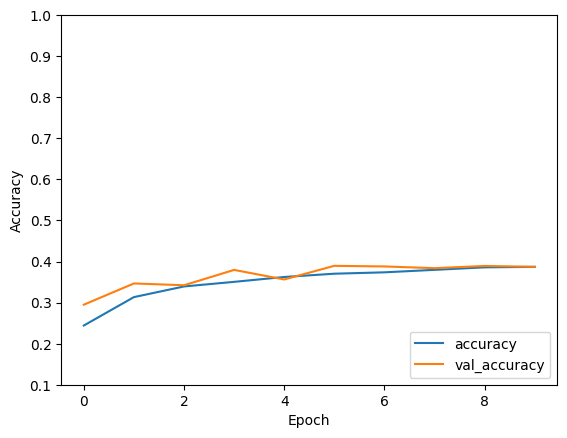

In [ ]:
# Evaluate the model (Metric: Accuracy)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = custom_resnet.evaluate(test_images_1,  test_labels_1, verbose=2)